# Clustering in the Embedding Space

This notebook clusters **node embeddings** extracted from **GraphSAGE model**

We **load a checkpoint** and run a single forward pass to get node embeddings `Z`, then we run clustering (KMeans / MeanShift) and interpret clusters.

In [27]:
from pathlib import Path

DATA_PATH = Path("dataset/wiki-RfA.txt.gz")
OUT_DIR = Path("clustering")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Checkpoint
CHECKPOINT_PATH = Path("checkpoints/votegnn_best.pt")

# Cache: extracted node embeddings
# Decomment it to use previously extracted node embeddings
EMB_CACHE_PATH = None #OUT_DIR / "node_embeddings_gnn.npy"

SEED = 42
K_RANGE = range(2, 21) # candidates for KMeans k


In [28]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, extract_node_features

# Device
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else
    ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
)
print("DEVICE:", DEVICE)


DEVICE: mps


## 1) Load and preprocess Wiki-RfA

We parse the SNAP `wiki-RfA.txt.gz` file and build:
- `edge_index`: `[2, E]` tensor of (src_id -> tgt_id)
- `vot`: vote label in `{-1, 0, +1}` (oppose, neutral, support)
- `dates`: `YYYYMMDD` (int) for optional temporal analyses


In [29]:
# 1) Load raw samples
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

pre = WikiRfAPreprocessor(DATA_PATH)
pre.load()

print("Loaded samples:", len(pre.samples))
print("Example sample:", pre.samples[0])  # (SRC, TGT, VOT, DAT)

# Build DataFrame for easier aggregation
df = pd.DataFrame(pre.samples, columns=["src_user", "tgt_user", "vot", "dat"])
df["dat"] = df["dat"].astype(int)
df["vot"] = df["vot"].astype(int)

df.head()

# 2) Encode users -> contiguous node ids [0..N-1]
users = sorted(set(df["src_user"]).union(set(df["tgt_user"])))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)

user_to_id = dict(zip(users, user_ids))
id_to_user = dict(zip(user_ids, users))

df["src"] = df["src_user"].map(user_to_id).astype(int)
df["tgt"] = df["tgt_user"].map(user_to_id).astype(int)

num_nodes = len(users)
num_edges = len(df)

print("num_nodes =", num_nodes, "min_id =", min(user_ids), "max_id =", max(user_ids))
print(f"num_edges={num_edges:,}")
df[["src","tgt","vot","dat"]].head()

Loading dataset from dataset/wiki-RfA.txt.gz...

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncyclopedia', 'Zagalejo', '14:47, 1 Julu 2012')
    Skipped edge: ('HJ Mitchell', 'Alan16', '20:44, 3 Janry 2010')
    Skipped edge: ('Pathoschild', 'Werdna', '31:29, 24 May 2008')
    Skipped edge: ('QuasyBoy', 'Imdanumber1', '17:44, 26 Mya 2007')
L

,src,tgt,vot,dat
0,9061,950,1,20130419
1,2177,950,1,20130420
2,4377,950,1,20130419
3,1976,950,1,20130420
4,6389,950,1,20130420


In [30]:
X = torch.tensor(df[["src","tgt"]].values, dtype=torch.long)
dates = df["dat"].values.astype(int)

edge_index = X.t().contiguous()
x_features = extract_node_features(edge_index=edge_index, edge_dates=dates, num_nodes=num_nodes)

data = HeteroData()
data['user'].x = x_features
data['user', 'votes', 'user'].edge_index = edge_index
data['user', 'rev_votes', 'user'].edge_index = edge_index.flip(0)
data = data.to(DEVICE)
metadata = data.metadata()



# LOAD CHECKPOINT

In [31]:
class HeteroPolarityGNN(nn.Module):
    def __init__(self, feature_dim, metadata, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()
        
        # Node embedding projection (applied to 'user' features)
        self.node_emb = nn.Linear(feature_dim, emb_dim)
        
        # Base Homogeneous GraphSAGE
        class BaseGNN(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = SAGEConv(emb_dim, hidden_dim)
                self.conv2 = SAGEConv(hidden_dim, hidden_dim)
            def forward(self, x, edge_index):
                x = self.conv1(x, edge_index)
                x = F.relu(x)
                x = F.dropout(x, p=dropout, training=self.training)
                x = self.conv2(x, edge_index)
                x = F.relu(x)
                return x
        
        # Convert to Hetero GNN
        self.hetero_gnn = to_hetero(BaseGNN(), metadata, aggr='sum')
        
        self.dropout = dropout
        edge_in = hidden_dim * 4
        
        # Head for polarity
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 3)
        )

    def forward(self, batch):
        # Dict for node embeddings
        x_dict = {node_type: self.node_emb(x) for node_type, x in batch.x_dict.items()}
        
        # Learn GNN embeddings
        z_dict = self.hetero_gnn(x_dict, batch.edge_index_dict)
        
        # Get embeddings for source and target nodes of the supervision edges
        # The edges we want to predict are in batch['user', 'votes', 'user'].edge_label_index
        # or batch.edge_label_index if LinkNeighborLoader behaves a certain way.
        # LinkNeighborLoader with edge_label_index returns edge_label_index for the target edge type.
        
        # For HeteroData batch from LinkNeighborLoader specifying edge_label_index for one type:
        # It's usually stored in batch[edge_type].edge_label_index
        
        edge_type = ('user', 'votes', 'user')
        if edge_type in batch.edge_index_dict:
             # LinkNeighborLoader typically puts the target edges in edge_label_index attribute of the edge store
             # But let's check accessing it.
             # In updated PyG versions, batch[edge_type].edge_label_index is correct.
             pass
        
        src, tgt = batch[edge_type].edge_label_index
        
        # Get user embeddings
        z = z_dict['user']
        h_src = z[src]
        h_tgt = z[tgt]
        
        # 4. Edge features
        e = torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)
        
        # 5. Predict
        return self.pol_mlp(e)


if not CHECKPOINT_PATH.exists():
    raise FileNotFoundError(
        f"Checkpoint not found: {CHECKPOINT_PATH}\n"
        "→ Save it from the training notebook by passing checkpoint_path=... to train_hierarchical()."
    )

model = HeteroPolarityGNN(
    feature_dim=data['user'].x.size(1),
    metadata=metadata,
    emb_dim=64,
    hidden_dim=256,
    dropout=0.2
).to(DEVICE)

def load_checkpoint_flexible(path: Path, model: nn.Module, map_location=DEVICE):
    """Load a checkpoint saved either as:
    - a full dict with key 'model_state' or 'state_dict'
    - or directly a state_dict
    Returns: (meta_dict, state_dict_loaded)
    """
    ckpt = torch.load(path, map_location=map_location)
    meta = {}
    if isinstance(ckpt, dict) and ("model_state" in ckpt or "state_dict" in ckpt):
        state = ckpt.get("model_state", ckpt.get("state_dict"))
        meta = {k: v for k, v in ckpt.items() if k not in ["model_state", "state_dict", "optimizer_state"]}
    elif isinstance(ckpt, dict):
        # Heuristic: treat dict as a raw state_dict
        state = ckpt
    else:
        raise ValueError(f"Unsupported checkpoint format at {path}")
    model.load_state_dict(state)
    return meta, state

meta, _ = load_checkpoint_flexible(CHECKPOINT_PATH, model, map_location=DEVICE)

print("Loaded checkpoint:", CHECKPOINT_PATH)
if meta:
    print("Checkpoint metadata:")
    for k, v in meta.items():
        if k in ["epoch", "best_metric"]:
            print(f" - {k}: {v}")

Loaded checkpoint: checkpoints/votegnn_best.pt
Checkpoint metadata:
 - epoch: 4
 - best_metric: 0.37143259606457796


/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/torch_geometric/nn/fx.py:132: UserWarning: Found function 'dropout' with keyword argument 'training'. During FX tracing, this will likely be baked in as a constant value. Consider replacing this function by a module to properly encapsulate its training flag.
  warnings.warn(f"Found function '{node.name}' with keyword "


In [32]:
# -------------------------------------------------------------------
# Extract node embeddings Z from the trained encoder (and cache them)
# -------------------------------------------------------------------
if EMB_CACHE_PATH and EMB_CACHE_PATH.exists():
    print("Found cached embeddings ->", EMB_CACHE_PATH)
    Z = np.load(EMB_CACHE_PATH)
else:
    model.eval()
    with torch.no_grad():
        x_dict = {'user': model.node_emb(data['user'].x)}
        z_dict = model.hetero_gnn(x_dict, data.edge_index_dict)
    Z = z_dict['user'].detach().cpu().numpy()
    if EMB_CACHE_PATH:
        np.save(EMB_CACHE_PATH, Z)
    print("Saved embeddings ->", EMB_CACHE_PATH)

print("Z shape:", Z.shape) # (num_users, hidden_dim)


Saved embeddings -> None
Z shape: (11128, 256)


In [33]:
# Quick sanity check: embeddings are finite
assert np.isfinite(Z).all(), "Found NaN/Inf in embeddings!"

## 3) Clustering embeddings

We run:
- **KMeans**: we sweep `k` and pick a value using internal metrics (Silhouette / CH / DB).
- **MeanShift**: bandwidth-based clustering (can produce variable number of clusters).

In [34]:
# Normalize embeddings
Z_norm = normalize(Z, norm="l2")

# Quick sanity check
print("Z_norm:", Z_norm.shape, "mean L2:", np.mean(np.linalg.norm(Z_norm, axis=1)))


Z_norm: (11128, 256) mean L2: 1.0


In [ ]:
# -------------------------
# KMeans
# -------------------------
K_MIN, K_MAX = 2, 20

Z_s = Z_norm

results = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    labels = km.fit_predict(Z_norm)
    sil = silhouette_score(Z_s, labels)
    ch = calinski_harabasz_score(Z_s, labels)
    db = davies_bouldin_score(Z_s, labels)

    results.append((k, sil, ch, db))

res_df = pd.DataFrame(results, columns=["k", "silhouette", "calinski_harabasz", "davies_bouldin"])
res_df.sort_values("silhouette", ascending=False).head(10)


,k,silhouette,calinski_harabasz,davies_bouldin
0,2,0.261689,3200.846769,1.763141
4,6,0.253023,2448.518239,1.502025
3,5,0.252868,2655.633153,1.506248
2,4,0.249398,2949.557211,1.515331
5,7,0.219097,2266.656021,1.661453
1,3,0.217216,3014.411688,1.572900
6,8,0.192234,2115.440565,1.734938
7,9,0.188706,2000.899182,1.780149
9,11,0.181887,1767.842542,1.778257
8,10,0.178028,1851.540634,1.881957


k_best: 2


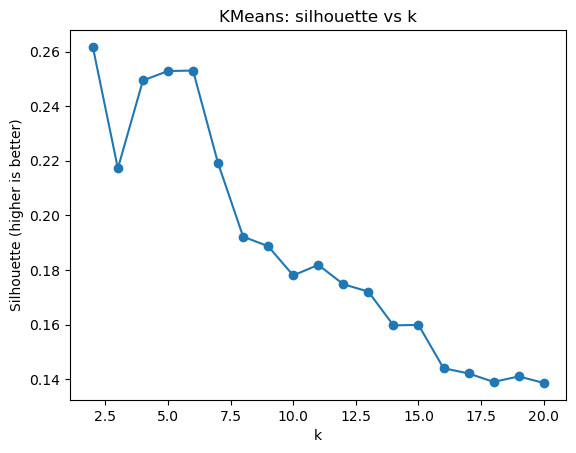

In [ ]:
# Choose best k by highest silhouette
k_best = int(res_df.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("k_best:", k_best)

plt.figure()
plt.plot(res_df["k"], res_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (higher is better)")
plt.title("KMeans: silhouette vs k")
plt.show()


In [37]:
# Fit final KMeans with best k
kmeans = KMeans(n_clusters=k_best, n_init=20, random_state=SEED)
labels_km = kmeans.fit_predict(Z_norm)

print("KMeans clusters:", np.unique(labels_km).size)
pd.Series(labels_km).value_counts().head()


KMeans clusters: 2


1    7607
0    3521
Name: count, dtype: int64

In [ ]:
# -------------------------
# MeanShift + dimensionality reduction
# -------------------------
PCA_DIMS = 10
pca = PCA(n_components=PCA_DIMS, random_state=SEED)
Z_pca = pca.fit_transform(Z_norm)

idx_ms = np.random.choice(Z_pca.shape[0], Z_pca.shape[0], replace=False)

bandwidth = estimate_bandwidth(Z_pca[idx_ms], quantile=0.2, n_samples=len(idx_ms))
print("Estimated bandwidth:", bandwidth)

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = meanshift.fit_predict(Z_pca)

print("MeanShift clusters:", np.unique(labels_ms).size)
pd.Series(labels_ms).value_counts().head()


Estimated bandwidth: 0.5926867480460172
MeanShift clusters: 2


0    8767
1    2361
Name: count, dtype: int64

## 4) Visualize clusters (t-SNE)


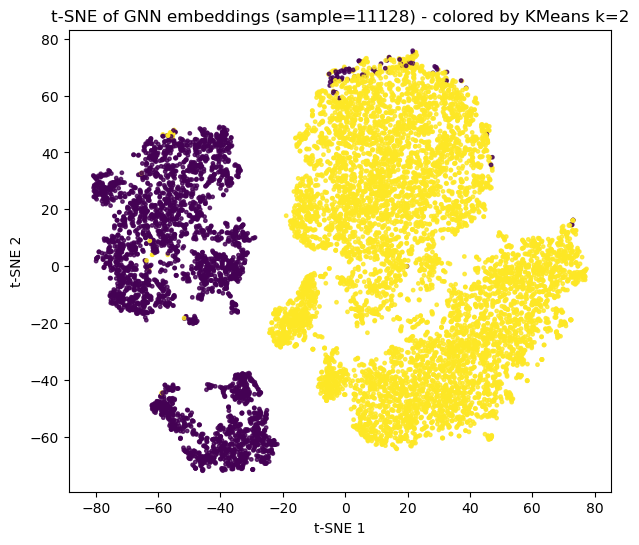

In [47]:
idx_vis = np.random.choice(Z_norm.shape[0], Z_norm.shape[0], replace=False)
Z_vis = Z_norm[idx_vis]
lab_vis = labels_km[idx_vis]

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
Z_2d = tsne.fit_transform(Z_vis)

plt.figure(figsize=(7, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], s=6, c=lab_vis, alpha=0.8)
plt.title(f"t-SNE of GNN embeddings (sample={len(idx_vis)}) - colored by KMeans k={k_best}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


## 5) Cluster interpretation via voting behavior

We compute node-level features from the *raw vote edges* and then aggregate by cluster:

- Activity: out-degree (votes cast), in-degree (votes received)
- Outgoing vote profile: %oppose / %neutral / %support
- Incoming vote profile: %oppose / %neutral / %support


In [48]:
# Build node-level vote profiles
# Outgoing (as voter)
out_deg = df.groupby("src").size().rename("out_deg")
in_deg  = df.groupby("tgt").size().rename("in_deg")

def counts_by_vote(col):
    # returns DataFrame indexed by node_id with columns vote_-1, vote_0, vote_1
    c = (
        df.groupby([col, "vot"])
          .size()
          .unstack(fill_value=0)
          .rename(columns={-1: "oppose", 0: "neutral", 1: "support"})
    )
    # ensure all columns exist
    for cc in ["oppose", "neutral", "support"]:
        if cc not in c.columns:
            c[cc] = 0
    return c[["oppose", "neutral", "support"]]

out_counts = counts_by_vote("src").add_prefix("out_")
in_counts  = counts_by_vote("tgt").add_prefix("in_")

node_stats = pd.DataFrame(index=np.arange(num_nodes))
node_stats = node_stats.join(out_deg).join(in_deg).join(out_counts).join(in_counts)
node_stats = node_stats.fillna(0).astype(int)

# Ratios (avoid division by zero)
node_stats["out_total"] = node_stats["out_oppose"] + node_stats["out_neutral"] + node_stats["out_support"]
node_stats["in_total"]  = node_stats["in_oppose"]  + node_stats["in_neutral"]  + node_stats["in_support"]

for prefix in ["out", "in"]:
    tot = node_stats[f"{prefix}_total"].replace(0, np.nan)
    node_stats[f"{prefix}_oppose_ratio"]  = node_stats[f"{prefix}_oppose"]  / tot
    node_stats[f"{prefix}_neutral_ratio"] = node_stats[f"{prefix}_neutral"] / tot
    node_stats[f"{prefix}_support_ratio"] = node_stats[f"{prefix}_support"] / tot


node_stats.head()


,out_deg,in_deg,out_oppose,out_neutral,out_support,in_oppose,in_neutral,in_support,out_total,in_total,out_oppose_ratio,out_neutral_ratio,out_support_ratio,in_oppose_ratio,in_neutral_ratio,in_support_ratio
0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
1,13,0,0,0,13,0,0,0,13,0,0.0,0.0,1.0,NaN,NaN,NaN
2,3,0,0,0,3,0,0,0,3,0,0.0,0.0,1.0,NaN,NaN,NaN
3,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
4,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN


In [49]:
# Attach cluster labels + usernames
nodes_df = pd.DataFrame({
    "node_id": np.arange(num_nodes),
    "username": [id_to_user[i] for i in range(num_nodes)],
    "cluster_kmeans": labels_km,
    "cluster_meanshift": labels_ms,
})
nodes_df = nodes_df.join(node_stats, on="node_id")

nodes_df.head()


,node_id,username,cluster_kmeans,cluster_meanshift,out_deg,in_deg,out_oppose,out_neutral,out_support,in_oppose,in_neutral,in_support,out_total,in_total,out_oppose_ratio,out_neutral_ratio,out_support_ratio,in_oppose_ratio,in_neutral_ratio,in_support_ratio
0,0,!---slappdash---!,1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
1,1,%D0%90,1,0,13,0,0,0,13,0,0,0,13,0,0.0,0.0,1.0,NaN,NaN,NaN
2,2,'sed,1,0,3,0,0,0,3,0,0,0,3,0,0.0,0.0,1.0,NaN,NaN,NaN
3,3,(.Y.),1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
4,4,(:Julien:),1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN


In [50]:
# Aggregate by KMeans cluster
cluster_summary = (
    nodes_df.groupby("cluster_kmeans")
    .agg(
        size=("node_id", "count"),

        in_total_zero_rate=("in_total", lambda s: (s == 0).mean()),
        out_total_zero_rate=("out_total", lambda s: (s == 0).mean()),

        out_deg_mean=("out_deg", "mean"),
        out_deg_median=("out_deg", "median"),
        in_deg_mean=("in_deg", "mean"),
        in_deg_median=("in_deg", "median"),

        out_support_ratio_mean=("out_support_ratio", "mean"),
        out_oppose_ratio_mean=("out_oppose_ratio", "mean"),
        out_neutral_ratio_mean=("out_neutral_ratio", "mean"),
        
        in_support_ratio_mean=("in_support_ratio", "mean"),
        in_oppose_ratio_mean=("in_oppose_ratio", "mean"),
        in_neutral_ratio_mean=("in_neutral_ratio", "mean"),
    )
    .sort_values("size", ascending=False)
)

cluster_summary


,size,in_total_zero_rate,out_total_zero_rate,out_deg_mean,out_deg_median,in_deg_mean,in_deg_median,out_support_ratio_mean,out_oppose_ratio_mean,out_neutral_ratio_mean,in_support_ratio_mean,in_oppose_ratio_mean,in_neutral_ratio_mean
cluster_kmeans,,,,,,,,,,,,,
1,7607,0.996582,0.000263,8.020639,2.0,1.108847,0.0,0.745970,0.213965,0.040066,0.623748,0.302142,0.074110
0,3521,0.022437,0.286850,36.297359,7.0,51.230048,38.0,0.761716,0.181952,0.056332,0.591032,0.339741,0.069227


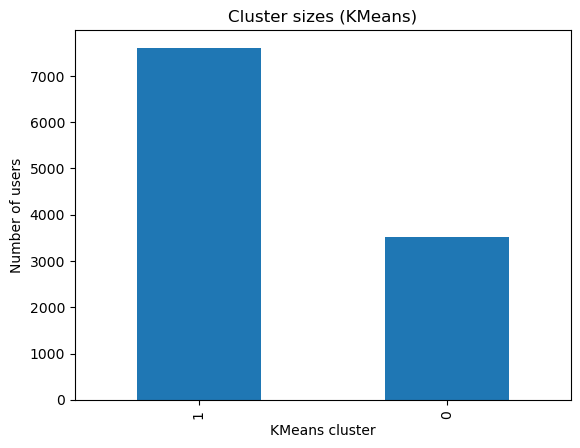

In [51]:
# Simple barplot: cluster sizes
plt.figure()
cluster_summary["size"].plot(kind="bar")
plt.xlabel("KMeans cluster")
plt.ylabel("Number of users")
plt.title("Cluster sizes (KMeans)")
plt.show()


In [52]:
# Representative users per cluster = closest to centroid in embedding space
centroids = kmeans.cluster_centers_
# compute squared distance to centroid for each node
d2 = np.sum((Z_norm - centroids[labels_km]) ** 2, axis=1)

nodes_df["km_dist2_centroid"] = d2

rep_per_cluster = (
    nodes_df.sort_values(["cluster_kmeans", "km_dist2_centroid"])
    .groupby("cluster_kmeans")
    .head(5)[["cluster_kmeans", "node_id", "username", "out_deg", "in_deg",
              "out_support_ratio", "out_oppose_ratio", "out_neutral_ratio",
              "km_dist2_centroid"]]
)

rep_per_cluster


,cluster_kmeans,node_id,username,out_deg,in_deg,out_support_ratio,out_oppose_ratio,out_neutral_ratio,km_dist2_centroid
2237,0,2237,D-Day,20,38,0.950000,0.050000,0.000000,0.159094
6188,0,6188,Mdd4696,23,42,0.608696,0.304348,0.086957,0.164625
7937,0,7937,Recurring dreams,31,51,0.903226,0.032258,0.064516,0.165550
674,0,674,Anynobody,12,47,0.833333,0.000000,0.166667,0.165921
1346,0,1346,Bornhj,43,33,0.953488,0.046512,0.000000,0.169512
7994,1,7994,Republitarian,5,0,0.200000,0.800000,0.000000,0.108689
7038,1,7038,OLP1999,2,0,0.000000,1.000000,0.000000,0.109001
3935,1,3935,Gretab,2,0,0.000000,1.000000,0.000000,0.111094
6596,1,6596,Mrs. Wolpoff,4,0,0.750000,0.250000,0.000000,0.111127
10318,1,10318,Webdinger,4,0,1.000000,0.000000,0.000000,0.111133


## 6) Export artifacts

We export:
- `node_embeddings.npy`
- `node_cluster_assignments.csv`
- `cluster_summary.csv`
- `representative_users.csv`


In [46]:
# Save tables
nodes_csv = OUT_DIR / "node_cluster_assignments.csv"
summary_csv = OUT_DIR / "cluster_summary_kmeans.csv"
rep_csv = OUT_DIR / "representative_users_kmeans.csv"
sweep_csv = OUT_DIR / "kmeans_k_sweep_metrics.csv"

nodes_df.to_csv(nodes_csv, index=False)
cluster_summary.to_csv(summary_csv)
rep_per_cluster.to_csv(rep_csv, index=False)
res_df.to_csv(sweep_csv, index=False)

print("Saved:")
print(" -", nodes_csv)
print(" -", summary_csv)
print(" -", rep_csv)
print(" -", sweep_csv)


Saved:
 - clustering/node_cluster_assignments.csv
 - clustering/cluster_summary_kmeans.csv
 - clustering/representative_users_kmeans.csv
 - clustering/kmeans_k_sweep_metrics.csv
